In [1]:
import pathlib
import sys
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import xarray as xr

import tobac

In [2]:
cmd_folder = pathlib.Path.cwd().parent.absolute()
if cmd_folder not in sys.path:
    sys.path.insert(0, str(cmd_folder))

from utils import data_formats, get_tb, calc_area_and_precip, is_track_mcs


In [3]:
model = "OBS"
season = "winter"
data_path = pathlib.Path("../data_in")
save_path = pathlib.Path("../data_out")

In [4]:
if season == "summer":
    dates = pd.date_range(datetime(2016, 8, 1), datetime(2016, 9, 9), freq="D")
    for MCS in data_formats.summer_datasets:
        if MCS.name == model:
            break
    else:
        raise ValueError(f"model {model} not found for season {season}")

if season == "winter":
    dates = pd.date_range(datetime(2020, 1, 20), datetime(2020, 2, 28), freq="D")
    for MCS in data_formats.winter_datasets:
        if MCS.name == model:
            break
    else:
        raise ValueError(f"model {model} not found for season {season}")

In [5]:
files = sorted(sum([MCS.glob_date(data_path, season, date) for date in dates], []))
files

[PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022800_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022801_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022802_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022803_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022804_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022805_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022806_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022807_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022808_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022809_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022810_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022811_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_pcp/merg_2020022812_4km-pixel.nc'),
 PosixPath('../data_in/Winter/OBS/olr_

In [6]:
print(datetime.now(), f"Loading {len(files)} files", flush=True)
ds = xr.open_mfdataset(files, combine="nested", concat_dim=MCS.time_dim)
ds = ds.assign_coords({MCS.time_dim: ds[MCS.time_dim].astype("datetime64[s]")})

2023-11-27 09:29:39.333062 Loading 24 files


In [7]:
ds

<xarray.Dataset>
Dimensions:           (time: 24, lat: 1200, lon: 3600)
Coordinates:
  * lat               (lat) float64 -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon               (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time              (time) datetime64[ns] 2020-02-28 ... 2020-02-28T23:00:00
Data variables:
    Tb                (time, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
Attributes: (12/15)
    BeginDate:       2020-02-28
    BeginTime:       00:00:00.000Z
    EndDate:         2020-02-28
    EndTime:         00:59:59.999Z
    FileHeader:      StartGranuleDateTime=2020-02-28T00:00:00.000Z;\nStopGran...
    InputPointer:    merg_2020022800_4km-pixel
    ...              ...
    remap_hostname:  nid00723
    remap_version:   4.9.7
    NCO:             netCDF Operators version 5.1.4 (Homepage = http://nco.sf...
    history:         Wed Jul 12 10:46:36 2023: ncks -O -d time,0 -d lat,-60.0...
    map_file:        /global/cscratch1/sd/feng045/waccem/map_data/weight_ir_4...
    input_file:      /tmp/feng045-6705/5/ncremap_tmp_att.nc.pid15378.flidx0

In [8]:
if MCS.convert_olr:
    bt = get_tb(ds[MCS.bt_var].compute()).to_iris()
else:
    bt = ds[MCS.bt_var].compute().to_iris()


In [9]:
bt

<iris 'Cube' of brightness_temperature / (K) (time: 24; latitude: 1200; longitude: 3600)>

In [10]:
dt = 3600  # in seconds
dxy = 11100  # in meter (for Latitude)

In [11]:
print(datetime.now(), f"Commencing feature detection", flush=True)
features = tobac.feature_detection_multithreshold(
    bt,
    dxy=dxy,
    threshold=[241, 233, 225],
    n_min_threshold=10,
    target="minimum",
    position_threshold="weighted_diff",
    PBC_flag="hdim_2",
    statistics={"feature_min_BT": np.nanmin},
)

features["feature_min_BT"] = features["feature_min_BT"].to_numpy().astype(float)


2023-11-27 09:29:46.949234 Commencing feature detection


In [12]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude
0,0,3,7.172438,1846.886199,38,241,236.958557,1,2020-02-28 00:00:00,2020-02-28 00:00:00,-59.232756,4.738620
1,0,5,6.816526,2469.385934,39,241,236.778259,2,2020-02-28 00:00:00,2020-02-28 00:00:00,-59.268347,66.988593
2,0,6,6.346133,2494.738512,33,241,236.228165,3,2020-02-28 00:00:00,2020-02-28 00:00:00,-59.315387,69.523851
3,0,7,5.074365,2506.595435,25,241,234.500183,4,2020-02-28 00:00:00,2020-02-28 00:00:00,-59.442564,70.709543
4,0,9,5.460038,2541.188438,30,241,237.771790,5,2020-02-28 00:00:00,2020-02-28 00:00:00,-59.403996,74.168844
...,...,...,...,...,...,...,...,...,...,...,...,...
27782,23,4966,1109.262582,95.994597,15,225,223.816559,27783,2020-02-28 23:00:00,2020-02-28 23:00:00,50.976258,-170.350540
27783,23,4967,1112.553172,145.889049,14,225,222.155838,27784,2020-02-28 23:00:00,2020-02-28 23:00:00,51.305317,-165.361095
27784,23,4969,1141.483527,124.755862,2873,225,211.665176,27785,2020-02-28 23:00:00,2020-02-28 23:00:00,54.198353,-167.474414
27785,23,4971,1123.561568,154.793963,27,225,221.447983,27786,2020-02-28 23:00:00,2020-02-28 23:00:00,52.406157,-164.470604


In [13]:
print(datetime.now(), f"Commencing tracking", flush=True)
features = tobac.linking_trackpy(
    features,
    bt,
    dt,
    dxy,
    v_max=1e2,
    method_linking="predict",
    adaptive_stop=0.2,
    adaptive_step=0.95,
    stubs=3,
    PBC_flag="hdim_2",
    min_h2=0,
    max_h2=3600,
)

Frame 23: 1210 trajectories present.


In [14]:
# Reduce tracks to only valid cells
features = features[features.cell != -1]
track_min_bt = features.groupby("cell").feature_min_BT.min()
valid_cells = track_min_bt.index[track_min_bt < 225]
features = features[np.isin(features.cell, valid_cells)]

In [15]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude,cell,time_cell
10,0,23,32.889750,1882.500379,25,241,234.483673,11,2020-02-28 00:00:00,2020-02-28 00:00:00,-56.661025,8.300038,11,0 days 00:00:00
33,0,102,108.859015,1665.242130,18,241,238.373306,34,2020-02-28 00:00:00,2020-02-28 00:00:00,-49.064098,-13.425787,34,0 days 00:00:00
44,0,140,142.117530,2328.772569,61,241,235.258026,45,2020-02-28 00:00:00,2020-02-28 00:00:00,-45.738247,52.927257,45,0 days 00:00:00
47,0,156,157.546768,2268.731498,124,241,231.012497,48,2020-02-28 00:00:00,2020-02-28 00:00:00,-44.195323,46.923150,48,0 days 00:00:00
64,0,230,225.077136,2229.009179,49,241,234.841125,65,2020-02-28 00:00:00,2020-02-28 00:00:00,-37.442286,42.950918,65,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27776,23,4955,1086.035722,1735.641087,27,225,221.915894,27777,2020-02-28 23:00:00,2020-02-28 23:00:00,48.653572,-6.385891,3964,0 days 12:00:00
27778,23,4961,1094.687616,1728.996013,11,225,222.720337,27779,2020-02-28 23:00:00,2020-02-28 23:00:00,49.518762,-7.050399,6471,0 days 03:00:00
27780,23,4963,1099.526247,157.148633,134,225,221.250107,27781,2020-02-28 23:00:00,2020-02-28 23:00:00,50.002625,-164.235137,6475,0 days 03:00:00
27784,23,4969,1141.483527,124.755862,2873,225,211.665176,27785,2020-02-28 23:00:00,2020-02-28 23:00:00,54.198353,-167.474414,4842,0 days 09:00:00


In [16]:
print(datetime.now(), f"Calculating merges and splits", flush=True)
merges = tobac.merge_split.merge_split_MEST(features, dxy, frame_len=1)

features["track"] = merges.feature_parent_track_id.data.astype(np.int64) + 1

track_start_time = features.groupby("track").time.min()
features["time_track"] = features.time - track_start_time[features.track].to_numpy()


2023-11-27 09:31:23.741382 Calculating merges and splits


In [17]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude,cell,time_cell,track,time_track
10,0,23,32.889750,1882.500379,25,241,234.483673,11,2020-02-28 00:00:00,2020-02-28 00:00:00,-56.661025,8.300038,11,0 days 00:00:00,1,0 days 00:00:00
33,0,102,108.859015,1665.242130,18,241,238.373306,34,2020-02-28 00:00:00,2020-02-28 00:00:00,-49.064098,-13.425787,34,0 days 00:00:00,2,0 days 00:00:00
44,0,140,142.117530,2328.772569,61,241,235.258026,45,2020-02-28 00:00:00,2020-02-28 00:00:00,-45.738247,52.927257,45,0 days 00:00:00,3,0 days 00:00:00
47,0,156,157.546768,2268.731498,124,241,231.012497,48,2020-02-28 00:00:00,2020-02-28 00:00:00,-44.195323,46.923150,48,0 days 00:00:00,4,0 days 00:00:00
64,0,230,225.077136,2229.009179,49,241,234.841125,65,2020-02-28 00:00:00,2020-02-28 00:00:00,-37.442286,42.950918,65,0 days 00:00:00,5,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27776,23,4955,1086.035722,1735.641087,27,225,221.915894,27777,2020-02-28 23:00:00,2020-02-28 23:00:00,48.653572,-6.385891,3964,0 days 12:00:00,1349,0 days 12:00:00
27778,23,4961,1094.687616,1728.996013,11,225,222.720337,27779,2020-02-28 23:00:00,2020-02-28 23:00:00,49.518762,-7.050399,6471,0 days 03:00:00,2131,0 days 03:00:00
27780,23,4963,1099.526247,157.148633,134,225,221.250107,27781,2020-02-28 23:00:00,2020-02-28 23:00:00,50.002625,-164.235137,6475,0 days 03:00:00,2132,0 days 03:00:00
27784,23,4969,1141.483527,124.755862,2873,225,211.665176,27785,2020-02-28 23:00:00,2020-02-28 23:00:00,54.198353,-167.474414,4842,0 days 09:00:00,1603,0 days 09:00:00


In [18]:
print(datetime.now(), f"Commencing segmentation", flush=True)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Warning: converting a masked element to nan.*",
)
segments, features = tobac.segmentation_2D(
    features, bt, dxy, threshold=241, target="minimum", PBC_flag="hdim_2"
)

2023-11-27 09:32:04.293801 Commencing segmentation


In [19]:
segments

<iris 'Cube' of segmentation_mask / (1) (time: 24; latitude: 1200; longitude: 3600)>

In [20]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude,cell,time_cell,track,time_track,ncells
10,0,23,32.889750,1882.500379,25,241,234.483673,11,2020-02-28 00:00:00,2020-02-28 00:00:00,-56.661025,8.300038,11,0 days 00:00:00,1,0 days 00:00:00,27
33,0,102,108.859015,1665.242130,18,241,238.373306,34,2020-02-28 00:00:00,2020-02-28 00:00:00,-49.064098,-13.425787,34,0 days 00:00:00,2,0 days 00:00:00,20
44,0,140,142.117530,2328.772569,61,241,235.258026,45,2020-02-28 00:00:00,2020-02-28 00:00:00,-45.738247,52.927257,45,0 days 00:00:00,3,0 days 00:00:00,58
47,0,156,157.546768,2268.731498,124,241,231.012497,48,2020-02-28 00:00:00,2020-02-28 00:00:00,-44.195323,46.923150,48,0 days 00:00:00,4,0 days 00:00:00,127
64,0,230,225.077136,2229.009179,49,241,234.841125,65,2020-02-28 00:00:00,2020-02-28 00:00:00,-37.442286,42.950918,65,0 days 00:00:00,5,0 days 00:00:00,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27776,23,4955,1086.035722,1735.641087,27,225,221.915894,27777,2020-02-28 23:00:00,2020-02-28 23:00:00,48.653572,-6.385891,3964,0 days 12:00:00,1349,0 days 12:00:00,480
27778,23,4961,1094.687616,1728.996013,11,225,222.720337,27779,2020-02-28 23:00:00,2020-02-28 23:00:00,49.518762,-7.050399,6471,0 days 03:00:00,2131,0 days 03:00:00,1525
27780,23,4963,1099.526247,157.148633,134,225,221.250107,27781,2020-02-28 23:00:00,2020-02-28 23:00:00,50.002625,-164.235137,6475,0 days 03:00:00,2132,0 days 03:00:00,2528
27784,23,4969,1141.483527,124.755862,2873,225,211.665176,27785,2020-02-28 23:00:00,2020-02-28 23:00:00,54.198353,-167.474414,4842,0 days 09:00:00,1603,0 days 09:00:00,10484


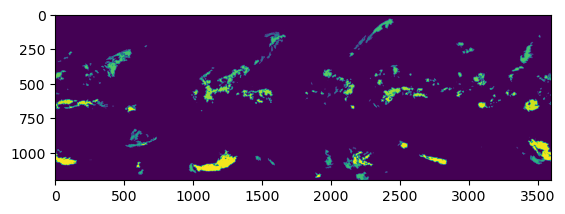

In [21]:
import matplotlib.pyplot as plt
plt.imshow(segments.data[0])

In [22]:
segments[0]

<iris 'Cube' of segmentation_mask / (1) (latitude: 1200; longitude: 3600)>

In [23]:
from iris.analysis.cartography import area_weights
from scipy.ndimage import labeled_comprehension
# Get area array and calculate area of each segment
segment_slice = segments[0]
segment_slice.coord("latitude").guess_bounds()
segment_slice.coord("longitude").guess_bounds()
area = area_weights(segment_slice, normalize=False)


/Users/jonesw/mambaforge-pypy3/envs/tobac_v1.5/lib/python3.11/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [24]:
area.shape

(1200, 3600)

In [25]:
features["area"] = np.nan
features["max_precip"] = np.nan
features["total_precip"] = np.nan

features_t = xr.CFTimeIndex(features["time"].to_numpy()).to_datetimeindex()
for time, mask in zip(ds[MCS.time_dim].data, segments.slices_over("time")):
    wh = features_t == time
    if np.any(wh):
        feature_areas = labeled_comprehension(
            area, mask.data, features[wh]["feature"], np.sum, area.dtype, np.nan
        )
        features.loc[wh, "area"] = feature_areas

        step_precip = ds[MCS.precip_var].sel({MCS.time_dim: time}).values
        max_precip = labeled_comprehension(
            step_precip,
            mask.data,
            features[wh]["feature"],
            np.max,
            area.dtype,
            np.nan,
        )

        features.loc[wh, "max_precip"] = max_precip

        feature_precip = labeled_comprehension(
            area * step_precip,
            mask.data,
            features[wh]["feature"],
            np.sum,
            area.dtype,
            np.nan,
        )

        features.loc[wh, "total_precip"] = feature_precip

In [26]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude,cell,time_cell,track,time_track,ncells,area,max_precip,total_precip
10,0,23,32.889750,1882.500379,25,241,234.483673,11,2020-02-28 00:00:00,2020-02-28 00:00:00,-56.661025,8.300038,11,0 days 00:00:00,1,0 days 00:00:00,27,1.831433e+09,0.000000,0.000000e+00
33,0,102,108.859015,1665.242130,18,241,238.373306,34,2020-02-28 00:00:00,2020-02-28 00:00:00,-49.064098,-13.425787,34,0 days 00:00:00,2,0 days 00:00:00,20,1.618265e+09,0.000000,0.000000e+00
44,0,140,142.117530,2328.772569,61,241,235.258026,45,2020-02-28 00:00:00,2020-02-28 00:00:00,-45.738247,52.927257,45,0 days 00:00:00,3,0 days 00:00:00,58,4.994116e+09,2.623382,9.797520e+09
47,0,156,157.546768,2268.731498,124,241,231.012497,48,2020-02-28 00:00:00,2020-02-28 00:00:00,-44.195323,46.923150,48,0 days 00:00:00,4,0 days 00:00:00,127,1.124230e+10,0.000000,0.000000e+00
64,0,230,225.077136,2229.009179,49,241,234.841125,65,2020-02-28 00:00:00,2020-02-28 00:00:00,-37.442286,42.950918,65,0 days 00:00:00,5,0 days 00:00:00,51,5.002562e+09,1.355845,7.201799e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27776,23,4955,1086.035722,1735.641087,27,225,221.915894,27777,2020-02-28 23:00:00,2020-02-28 23:00:00,48.653572,-6.385891,3964,0 days 12:00:00,1349,0 days 12:00:00,480,3.841629e+10,17.350080,1.888791e+11
27778,23,4961,1094.687616,1728.996013,11,225,222.720337,27779,2020-02-28 23:00:00,2020-02-28 23:00:00,49.518762,-7.050399,6471,0 days 03:00:00,2131,0 days 03:00:00,1525,1.237567e+11,17.294361,3.385757e+11
27780,23,4963,1099.526247,157.148633,134,225,221.250107,27781,2020-02-28 23:00:00,2020-02-28 23:00:00,50.002625,-164.235137,6475,0 days 03:00:00,2132,0 days 03:00:00,2528,2.060025e+11,4.082368,1.961458e+11
27784,23,4969,1141.483527,124.755862,2873,225,211.665176,27785,2020-02-28 23:00:00,2020-02-28 23:00:00,54.198353,-167.474414,4842,0 days 09:00:00,1603,0 days 09:00:00,10484,7.467839e+11,16.707603,2.177534e+11


In [27]:
from utils import max_consecutive_true

consecutive_precip_max = features.groupby("track").apply(
    lambda df: max_consecutive_true(
        df.groupby("time").max_precip.max().to_numpy() >= 10
    )
)
consecutive_area_max = features.groupby("track").apply(
    lambda df: max_consecutive_true(
        df.groupby("time").area.max().to_numpy() >= 4e10
    )
)
max_total_precip = features.groupby("track").apply(
    lambda df: df.groupby("time").total_precip.sum().max()
)

In [28]:
(consecutive_precip_max, consecutive_area_max, max_total_precip)

(track
 1       0
 2       2
 3       0
 4       1
 5       1
        ..
 2229    2
 2230    0
 2231    2
 2232    3
 2233    0
 Length: 2233, dtype: int64,
 track
 1       0
 2       3
 3       4
 4       3
 5       2
        ..
 2229    1
 2230    1
 2231    0
 2232    3
 2233    0
 Length: 2233, dtype: int64,
 track
 1       2.715836e+08
 2       7.881256e+11
 3       4.356100e+10
 4       3.143625e+11
 5       2.875417e+10
             ...     
 2229    6.693095e+10
 2230    5.442930e+10
 2231    1.372729e+11
 2232    1.925586e+12
 2233    0.000000e+00
 Length: 2233, dtype: float64)

In [29]:
is_mcs = np.logical_and.reduce(
    [
        consecutive_precip_max >= 4,
        consecutive_area_max >= 4,
        max_total_precip >= 2e10,
    ]
)

mcs_flag = pd.DataFrame(data=is_mcs, index=consecutive_precip_max.index)

In [30]:
mcs_flag

,0
track,
1,False
2,False
3,False
4,False
5,False
...,...
2229,False
2230,False
2231,False


In [31]:
np.sum(mcs_flag)

0    100
dtype: int64

In [32]:
features["time"] = xr.CFTimeIndex(features["time"].to_numpy()).to_datetimeindex()

# Prepare output dataset
print(datetime.now(), f"Preparing output", flush=True)
out_ds = features.set_index(features.feature).to_xarray()

out_ds = out_ds.rename_vars(
    {
        "cell": "feature_cell_id",
        "track": "feature_track_id",
        "hdim_1": "y",
        "hdim_2": "x",
        "num": "detection_pixel_count",
        "feature_min_BT": "min_BT",
        "ncells": "segmentation_pixel_count",
    }
)

out_ds["track_is_mcs"] = mcs_flag.to_xarray()[0]

feature_is_mcs = out_ds.track_is_mcs.loc[out_ds.feature_track_id]

out_ds["feature_is_mcs"] = feature_is_mcs

all_feature_labels = xr.DataArray.from_iris(segments)
all_feature_labels.name = "all_feature_labels"

mcs_feature_labels = all_feature_labels * np.isin(
    all_feature_labels, out_ds.feature.values[out_ds.feature_is_mcs]
)
mcs_feature_labels.name = "mcs_feature_labels"

out_ds = out_ds.assign_coords(all_feature_labels.coords)

out_ds = xr.merge([out_ds, all_feature_labels, mcs_feature_labels])

out_ds.assign_attrs(
    title=f"{season} {model} MCS mask file",
    tracker="tobac",
    version=f"{tobac.__version__}",
    created_on=f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
)

2023-11-27 09:36:20.689450 Preparing output


<xarray.Dataset>
Dimensions:                   (feature: 16373, time: 24, track: 2233,
                               lat: 1200, lon: 3600)
Coordinates:
  * feature                   (feature) int64 11 34 45 48 ... 27781 27785 27787
  * time                      (time) datetime64[ns] 2020-02-28 ... 2020-02-28...
  * track                     (track) int64 1 2 3 4 5 ... 2230 2231 2232 2233
  * lat                       (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
  * lon                       (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
Data variables: (12/22)
    frame                     (feature) int64 0 0 0 0 0 0 ... 23 23 23 23 23 23
    idx                       (feature) int64 23 102 140 156 ... 4963 4969 4975
    y                         (feature) float64 32.89 108.9 ... 1.155e+03
    x                         (feature) float64 1.883e+03 ... 2.312e+03
    detection_pixel_count     (feature) int64 25 18 61 124 49 ... 11 134 2873 18
    threshold_value           (feature) int64 241 241 241 241 ... 225 225 225
    ...                        ...
    max_precip                (feature) float64 0.0 0.0 2.623 ... 16.71 3.861
    total_precip              (feature) float64 0.0 0.0 ... 2.178e+11 3.222e+11
    track_is_mcs              (track) bool False False False ... False False
    feature_is_mcs            (feature) bool False False False ... True True
    all_feature_labels        (time, lat, lon) int32 ...
    mcs_feature_labels        (time, lat, lon) int32 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    title:       winter OBS MCS mask file
    tracker:     tobac
    version:     1.5.1
    created_on:  2023-11-27 09:36:21

In [33]:
out_ds

<xarray.Dataset>
Dimensions:                   (feature: 16373, time: 24, track: 2233,
                               lat: 1200, lon: 3600)
Coordinates:
  * feature                   (feature) int64 11 34 45 48 ... 27781 27785 27787
  * time                      (time) datetime64[ns] 2020-02-28 ... 2020-02-28...
  * track                     (track) int64 1 2 3 4 5 ... 2230 2231 2232 2233
  * lat                       (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
  * lon                       (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
Data variables: (12/22)
    frame                     (feature) int64 0 0 0 0 0 0 ... 23 23 23 23 23 23
    idx                       (feature) int64 23 102 140 156 ... 4963 4969 4975
    y                         (feature) float64 32.89 108.9 ... 1.155e+03
    x                         (feature) float64 1.883e+03 ... 2.312e+03
    detection_pixel_count     (feature) int64 25 18 61 124 49 ... 11 134 2873 18
    threshold_value           (feature) int64 241 241 241 241 ... 225 225 225
    ...                        ...
    max_precip                (feature) float64 0.0 0.0 2.623 ... 16.71 3.861
    total_precip              (feature) float64 0.0 0.0 ... 2.178e+11 3.222e+11
    track_is_mcs              (track) bool False False False ... False False
    feature_is_mcs            (feature) bool False False False ... True True
    all_feature_labels        (time, lat, lon) int32 ...
    mcs_feature_labels        (time, lat, lon) int32 0 0 0 0 0 0 ... 0 0 0 0 0 0

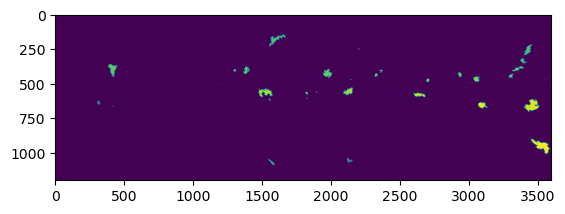

In [34]:
import matplotlib.pyplot as plt
plt.imshow(mcs_feature_labels.data[0])

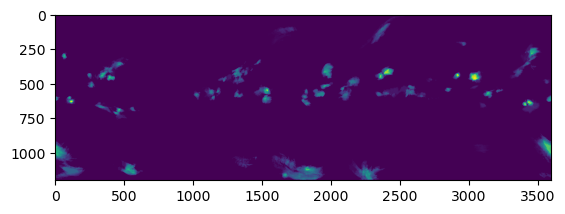

In [35]:
plt.imshow(mcs_feature_labels.mean("time"))

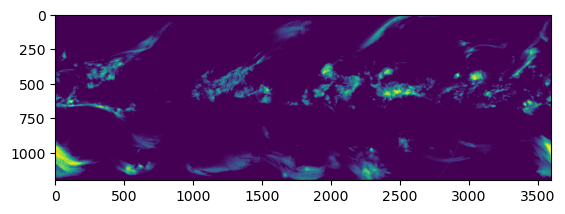

In [36]:
plt.imshow(out_ds.all_feature_labels.mean("time"))

In [48]:
all_cell_labels = all_feature_labels.copy()
all_cell_labels.name = "all_cell_labels"
all_track_labels = all_feature_labels.copy()
all_track_labels.name = "all_track_labels"
wh_all_labels = np.flatnonzero(all_feature_labels)
all_cell_labels.data.ravel()[wh_all_labels] = out_ds.feature_cell_id.loc[
    all_feature_labels.data.ravel()[wh_all_labels]
]
all_track_labels.data.ravel()[wh_all_labels] = out_ds.feature_track_id.loc[
    all_feature_labels.data.ravel()[wh_all_labels]
]

In [49]:
all_cell_labels, all_track_labels

(<xarray.DataArray 'all_cell_labels' (time: 24, lat: 1200, lon: 3600)>
 [103680000 values with dtype=int32]
 Coordinates:
   * time     (time) datetime64[ns] 2020-02-28 ... 2020-02-28T23:00:00
   * lat      (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
   * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9
 Attributes:
     long_name:      segmentation_mask
     cell_measures:  area: area,
 <xarray.DataArray 'all_track_labels' (time: 24, lat: 1200, lon: 3600)>
 [103680000 values with dtype=int32]
 Coordinates:
   * time     (time) datetime64[ns] 2020-02-28 ... 2020-02-28T23:00:00
   * lat      (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
   * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9
 Attributes:
     long_name:      segmentation_mask
     cell_measures:  area: area)

In [50]:
mcs_cell_labels = mcs_feature_labels.copy()
mcs_cell_labels.name = "mcs_cell_labels"
mcs_track_labels = mcs_feature_labels.copy()
mcs_track_labels.name = "mcs_track_labels"
wh_mcs_labels = np.flatnonzero(mcs_feature_labels)
mcs_cell_labels.data.ravel()[wh_mcs_labels] = out_ds.feature_cell_id.loc[
    mcs_feature_labels.data.ravel()[wh_mcs_labels]
]
mcs_track_labels.data.ravel()[wh_mcs_labels] = out_ds.feature_track_id.loc[
    mcs_feature_labels.data.ravel()[wh_mcs_labels]
]

In [51]:
mcs_cell_labels, mcs_track_labels

(<xarray.DataArray 'mcs_cell_labels' (time: 24, lat: 1200, lon: 3600)>
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
 ...
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0,